# Importing of libraries

In [1]:
########################################
#                                      #
#        Installation Packages         #
#                                      #
########################################

#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install lightgbm
#!{sys.executable} -m pip install dask
#!{sys.executable} -m pip install dask-ml
#!{sys.executable} -m pip install joblib
#!{sys.executable} -m pip install scikit-plot

In [63]:
########################################
#                                      #
#           Import Libraries           #
#                                      #
########################################

import os
import sys
import pandas as pd
import numpy as np

########################################
#                                      #
#            Visualization             #
#                                      #
########################################

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import classification_report

########################################
#                                      #
#     Import Regression Algorithms     #
#                                      #
########################################

from operator import itemgetter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor, LinearRegression, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingRegressor
from dask.distributed import Client
from joblib import parallel_backend
from joblib import dump
from dask_ml.model_selection import GridSearchCV

########################################
#                                      #
#          Data Handling Tools         #
#                                      #
########################################

from sklearn.model_selection import train_test_split
from copy import deepcopy


# Extraction of CSV

In [3]:
########################################
#                                      #
#     Extraction of data from CSV      #
#                                      #
########################################

# Initializing the list variables 
data_files = []
pre_data = []

# Compiling all the .csv files together into data_files
for f in next(os.walk("Downloads/IOT/Assignment2/Data/"))[2]:
    if f.endswith("csv"):
        data_files.append(f)
        
# Extracting all the records into data        
for file in data_files:
    df = pd.read_csv("Downloads/IOT/Assignment2/Data/" + file)
    pre_data.append(df)
    
# Combining all the records into 'data'    
pre_data = pd.concat(pre_data)

# Extracting all the records into 'label'
label = pd.read_csv('Downloads/IOT/Assignment2/Label/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

# Data Cleaning - 'label' 

In [4]:
#################################################
#                                               #
#    Checking more details about the 'label'    #
#                                               #
#################################################

label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20018 entries, 0 to 20017
Data columns (total 2 columns):
bookingID    20018 non-null int64
label        20018 non-null int64
dtypes: int64(2)
memory usage: 312.9 KB


In [5]:
###########################################################
#                                                         #
#    Checking if there is any 'null' values in 'label'    #
#                                                         #
###########################################################

label.isnull().any()

bookingID    False
label        False
dtype: bool

In [6]:
##############################################################
#                                                            #
#    Check if the unique values corresponds to each other    #
#                                                            #
##############################################################

len(pre_data['bookingID'].unique())

20000

In [7]:
# Check if the unique values corresponds to each other
len(label['bookingID'].unique())

20000

In [8]:
# As 'label' contains 20018 records but with only 20000 records as unique, there will bound to have duplicates
label.duplicated(subset="bookingID").any()

True

In [9]:
# Dropping the first row of the duplicated bookingid and keep the second row
label.drop_duplicates(subset="bookingID", keep="last", inplace=True)

In [10]:
# Double check if there is anymore duplicates
label.duplicated(subset="bookingID").any()

False

# Data Cleaning - 'data'

For the 'pre_data' dataset, there is a total records of 16135561 when there is only 20000 unique records. With the repetition of bookingID in 'pre_data', it might not be suitable to the model that is doing the prediction. Thus, for 'pre_data' dataset, it will be assumed that multiple bookingIDs refer to one entire trip.

Therefore, these 16135561 records will be reduced to 20000 records into 'data'. Instead of dropping the rows without calculation, we decided to group these records by bookingID with accumulating the mean, sum, max and min value for each columns. This in turn will create more columns, will help us better analyze which aspect will improve the predict for each record. 

In [11]:
# Checking more details about the 'pre_data'
pre_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16135561 entries, 0 to 1613561
Data columns (total 11 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtypes: float64(10), int64(1)
memory usage: 1.4 GB


In [12]:
# Checking if there is any 'null' values in 'pre_data'
pre_data.isnull().any()

bookingID         False
Accuracy          False
Bearing           False
acceleration_x    False
acceleration_y    False
acceleration_z    False
gyro_x            False
gyro_y            False
gyro_z            False
second            False
Speed             False
dtype: bool

In [13]:
# Checking if there is any duplicated records in 'pre_data'
pre_data.duplicated().any()

False

In [14]:
# Grouping the bookingID together and generating the 'mean', 'sum', 'max', 'min' for each column into 'data'
data = pd.DataFrame()
for col in pre_data.columns:
    if col != "bookingID" and col != "label":
        temp = pre_data.groupby("bookingID")[col].agg(["mean", "sum", "max", "min"])
        data[col + "_mean"] = temp["mean"]
        data[col + "_sum"] = temp["sum"]
        data[col + "_max"] = temp["max"]
        data[col + "_min"] = temp["min"]

In [15]:
# Checking if the records have been reduced to 20000 records
len(data)

20000

In [16]:
# Merging the 'label' and 'data' together 
data = pd.merge(data, label, on="bookingID")

In [17]:
# Counterchecking the number of columns and data to ensure that everything is ready for features selection
data.head(5)

,bookingID,Accuracy_mean,Accuracy_sum,Accuracy_max,Accuracy_min,Bearing_mean,Bearing_sum,Bearing_max,Bearing_min,acceleration_x_mean,...,gyro_z_min,second_mean,second_sum,second_max,second_min,Speed_mean,Speed_sum,Speed_max,Speed_min,label
0,0,10.165339,10206.000,48.000,4.0,176.526099,177232.203582,359.979767,0.037464,-0.711264,...,-0.731892,903.526892,907141.0,1589.0,0.0,8.994822,9030.801222,22.946083,-1.0,0
1,1,3.718763,3164.667,7.709,3.0,124.198590,105693.000000,337.000000,0.000000,-0.525406,...,-0.121265,581.175088,494580.0,1034.0,0.0,7.881588,6707.231233,21.882141,-1.0,1
2,2,3.930626,766.472,8.000,3.0,173.794872,33890.000000,354.000000,1.000000,0.306786,...,-0.125907,339.441026,66191.0,825.0,0.0,3.157213,615.656528,9.360483,0.0,1
3,4,10.000000,10940.000,10.000,10.0,151.807013,166076.872711,353.855377,2.271227,-0.365117,...,-0.348189,547.495430,598960.0,1094.0,0.0,6.150996,6729.190006,19.780001,0.0,1
4,6,4.586721,5022.460,12.000,3.0,197.812785,216605.000000,359.000000,0.000000,0.490616,...,-0.348345,547.000000,598965.0,1094.0,0.0,4.628921,5068.669039,16.394695,0.0,0


In [18]:
# Checking if there is any 'null' values in 'data'
data.isnull().any()

bookingID              False
Accuracy_mean          False
Accuracy_sum           False
Accuracy_max           False
Accuracy_min           False
Bearing_mean           False
Bearing_sum            False
Bearing_max            False
Bearing_min            False
acceleration_x_mean    False
acceleration_x_sum     False
acceleration_x_max     False
acceleration_x_min     False
acceleration_y_mean    False
acceleration_y_sum     False
acceleration_y_max     False
acceleration_y_min     False
acceleration_z_mean    False
acceleration_z_sum     False
acceleration_z_max     False
acceleration_z_min     False
gyro_x_mean            False
gyro_x_sum             False
gyro_x_max             False
gyro_x_min             False
gyro_y_mean            False
gyro_y_sum             False
gyro_y_max             False
gyro_y_min             False
gyro_z_mean            False
gyro_z_sum             False
gyro_z_max             False
gyro_z_min             False
second_mean            False
second_sum    

In [19]:
# Checking if there is any duplicated records in 'data'
data.duplicated().any()

False

In [20]:
# Doing a final data cleaning of 'data' by removing the column 'bookingID' and resetting the index
data = data.drop(columns=["bookingID"]).reset_index(drop=True)

# Generation and Selection of Features

Generation:

- Usage of other columns to generate new features

Selection:

- Eliminating any outliers
- Narrowing down the features that can be used for each model 
- Selecting which regression model to used for this prediction
- Selecting between 'hypertuning' and 'stacking techniques'

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
Accuracy_mean          20000 non-null float64
Accuracy_sum           20000 non-null float64
Accuracy_max           20000 non-null float64
Accuracy_min           20000 non-null float64
Bearing_mean           20000 non-null float64
Bearing_sum            20000 non-null float64
Bearing_max            20000 non-null float64
Bearing_min            20000 non-null float64
acceleration_x_mean    20000 non-null float64
acceleration_x_sum     20000 non-null float64
acceleration_x_max     20000 non-null float64
acceleration_x_min     20000 non-null float64
acceleration_y_mean    20000 non-null float64
acceleration_y_sum     20000 non-null float64
acceleration_y_max     20000 non-null float64
acceleration_y_min     20000 non-null float64
acceleration_z_mean    20000 non-null float64
acceleration_z_sum     20000 non-null float64
acceleration_z_max     20000 non-null float64
acceleration_z_mi

In [22]:
# Computes the pairwise correlation between columns
#corr=data.corr()

#fig, ax = plt.subplots(figsize=(20,20))
#ax = sns.heatmap(
#    corr, 
 #   vmin=-1, vmax=1, center=0,
  #  cmap=sns.diverging_palette(20, 220, n=200),
   # square=True
#)
#ax.set_xticklabels(
 #   ax.get_xticklabels(),
 #   horizontalalignment='right'
#);

In [23]:
# After using sns.heatmap, it have shown that 'second_min' have no relation towards 'label'
data.drop(columns=["second_min"], inplace=True)

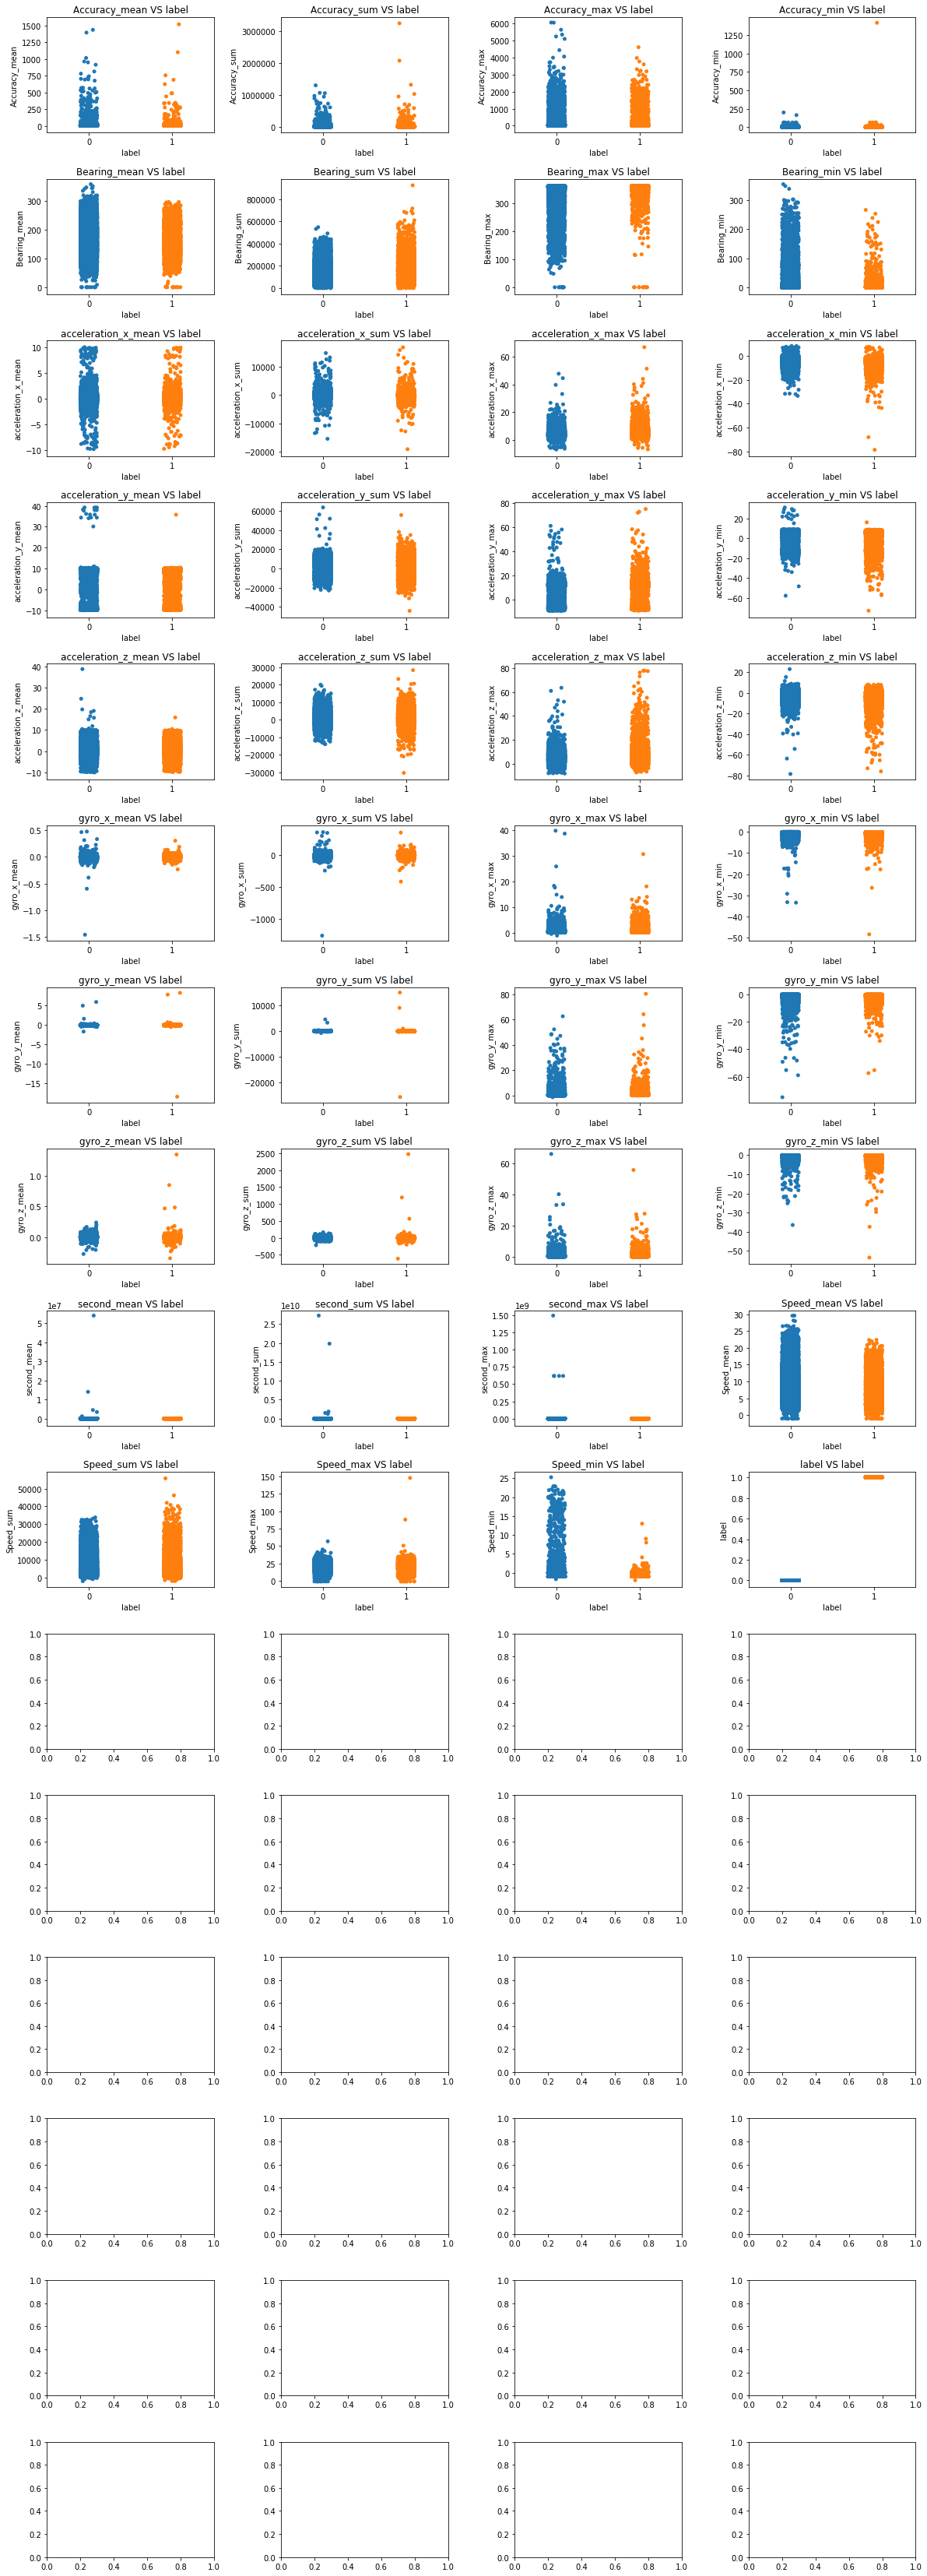

In [24]:
# Identifying which features that can differentiate between 'dangerous' and 'not dangerous' 
fig, axes = plt.subplots(16, 4)
fig.set_figheight(60)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(data.columns)):
    row = i // 4
    column = i % 4
    sns.stripplot(x="label", y=data.columns[i], data=data, ax=axes[row, column]).set_title("{} VS label".format(data.columns[i]))

In [25]:
# Calculating the standard deviations to get rid of the outliers [seconds]
def calculate_std_upper_lower(data_input, std_int=2):
    
    mean, std = data_input.mean(), data_input.std()
    cut_off = std * std_int
    lower, upper = mean - cut_off, mean + cut_off
    return (lower, upper)

In [26]:
#####################################################
#                                                   # 
#    Calculating 'seconds' standard deviation       #
#                                                   #
#####################################################

second_mean_lower, second_mean_upper = calculate_std_upper_lower(data.second_mean)
second_sum_lower, second_sum_upper = calculate_std_upper_lower(data.second_sum)
second_max_lower, second_max_upper = calculate_std_upper_lower(data.second_max)

####################################################
#                                                  #
#        Getting rid of 'seconds' outliers         #
#                                                  #
####################################################

data = data.loc[(data.second_mean > second_mean_lower) & (data.second_mean < second_mean_upper)]
data = data.loc[(data.second_sum > second_sum_lower) & (data.second_sum < second_sum_upper)]
data = data.loc[(data.second_max > second_max_lower) & (data.second_max < second_max_upper)]


"######################################################\n#                                                    #\n#    Calculating 'acceleration' standard deviation   #\n#                                                    #\n######################################################\n\nacc_x_mean_lower, acc_x_mean_upper = calculate_std_upper_lower(data.acceleration_x_mean)\nacc_y_mean_lower, acc_y_mean_upper = calculate_std_upper_lower(data.acceleration_y_mean)\nacc_z_mean_lower, acc_z_mean_upper = calculate_std_upper_lower(data.acceleration_z_mean)\nacc_x_min_lower, acc_x_min_upper = calculate_std_upper_lower(data.acceleration_x_min)\nacc_y_min_lower, acc_y_min_upper = calculate_std_upper_lower(data.acceleration_y_min)\nacc_z_min_lower, acc_z_min_upper = calculate_std_upper_lower(data.acceleration_z_min)\nacc_x_max_lower, acc_x_max_upper = calculate_std_upper_lower(data.acceleration_x_max)\nacc_y_max_lower, acc_y_max_upper = calculate_std_upper_lower(data.acceleration_y_max)\nacc_z_max_lo

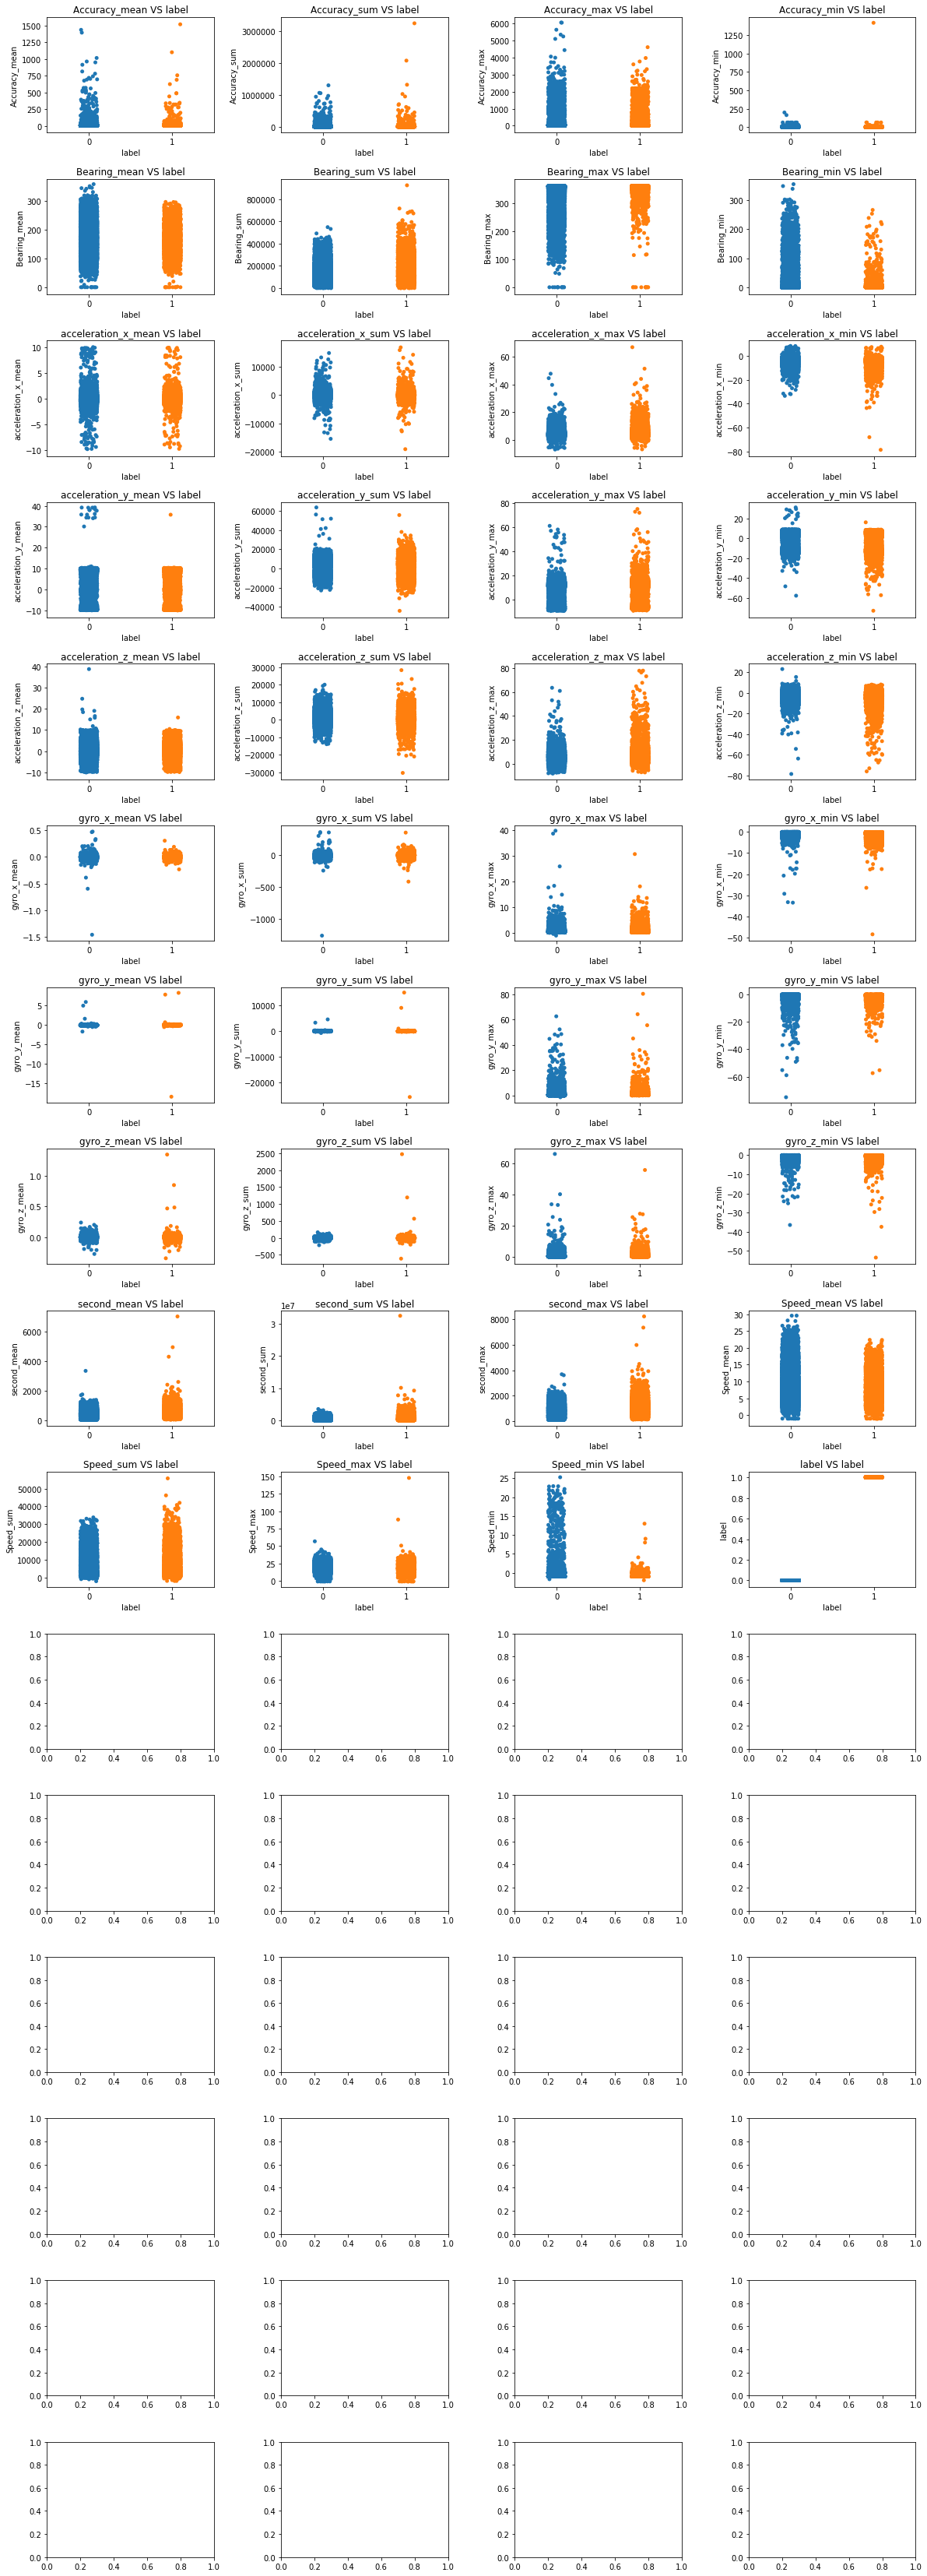

In [27]:
# Identifying which features that can differentiate between 'dangerous' and 'not dangerous' 
fig, axes = plt.subplots(16, 4)
fig.set_figheight(60)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(data.columns)):
    row = i // 4
    column = i % 4
    sns.stripplot(x="label", y=data.columns[i], data=data, ax=axes[row, column]).set_title("{} VS label".format(data.columns[i]))

In [28]:
# Checking the length of 'data' after getting rid of outliners
len(data)

19995

In [29]:
# Generation of more features - Velocity, Distance, Rotation angles
for col in data.columns:
    if col.startswith("second"):
        agg_method = col.split("_")[1]
        data["distance_" + agg_method] = data[col] * data["Speed_" + agg_method]
        data["velocity_x_" + agg_method] = data[col] * data["acceleration_x_" + agg_method]
        data["velocity_y_" + agg_method] = data[col] * data["acceleration_y_" + agg_method]
        data["velocity_z_" + agg_method] = data[col] * data["acceleration_z_" + agg_method]
        data["angle_x_" + agg_method] = data[col] * data["gyro_x_" + agg_method]
        data["angle_y_" + agg_method] = data[col] * data["gyro_y_" + agg_method]
        data["angle_z_" + agg_method] = data[col] * data["gyro_z_" + agg_method]

In [30]:
# Analyzing the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19995 entries, 0 to 19999
Data columns (total 61 columns):
Accuracy_mean          19995 non-null float64
Accuracy_sum           19995 non-null float64
Accuracy_max           19995 non-null float64
Accuracy_min           19995 non-null float64
Bearing_mean           19995 non-null float64
Bearing_sum            19995 non-null float64
Bearing_max            19995 non-null float64
Bearing_min            19995 non-null float64
acceleration_x_mean    19995 non-null float64
acceleration_x_sum     19995 non-null float64
acceleration_x_max     19995 non-null float64
acceleration_x_min     19995 non-null float64
acceleration_y_mean    19995 non-null float64
acceleration_y_sum     19995 non-null float64
acceleration_y_max     19995 non-null float64
acceleration_y_min     19995 non-null float64
acceleration_z_mean    19995 non-null float64
acceleration_z_sum     19995 non-null float64
acceleration_z_max     19995 non-null float64
acceleration_z_mi

# Manually Selecting Features

In [31]:
# Identifying the importance of each column
pd.DataFrame(abs(data.corr()['label']).sort_values(ascending = False))

,label
label,1.000000
second_max,0.305728
second_mean,0.301689
velocity_x_max,0.267997
second_sum,0.263225
distance_max,0.251179
velocity_z_max,0.248550
Bearing_sum,0.196408
distance_sum,0.192947
angle_x_max,0.191057


In [32]:
# These features are handpicked after analyzing the graph which display a distinct difference between 'dangerous' and 'not dangerous'
manually_selected_features = ["second_max", "second_mean", "second_sum", "velocity_x_max", "distance_max", "velocity_z_max"]

# Defining 'data' as the testing dataset

In [33]:
# Setting up the testing dataset
X_test = data.drop(columns=["label"]).reset_index(drop=True)
y_test = data.label.reset_index(drop=True)

In [34]:
len(y_test)

19995

# Retreiving Importance of feature table

In [35]:
def generate_sorted_feature_importance(columns_name, feature_importances):
    feature_importance_map = {}
    for i in range(len(columns_name)):
        feature_importance_map[columns_name[i]] = feature_importances[i]
    sorted_feature_importance = dict(sorted(feature_importance_map.items(), key=itemgetter(1)))
    return sorted_feature_importance

def plot_feature_importance(sorted_feature_importance, ax, title):
    num_feature = 20
    bp = sns.barplot(list(sorted_feature_importance.keys())[-num_feature:], list(sorted_feature_importance.values())[-num_feature:], ax=ax)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    bp.set_title(title)
    return bp

# Tree Based Model's Feature Selection

In [36]:
# Initializing all the Tree Based Models to see which features are important for each model [Regressor]
tree_based_models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "ExtraTrees": ExtraTreesRegressor(),
    "XGB": XGBRegressor(),
    "LGBM": LGBMRegressor()
}

In [37]:
# Fitting the testing dataset into each Tree Based Models
for _, clf in tree_based_models.items():
    clf.fit(X_test, y_test)

In [38]:
# Generating the feature importance table to identify which features are crucial for the respective model
clf_features_importance = pd.DataFrame()
for name, clf in tree_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X_test.columns, clf.feature_importances_)
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [39]:
# Viewing the top 10 features for each model
clf_features_importance[-10:]

,DecisionTree,RandomForest,AdaBoost,GradientBoosting,ExtraTrees,XGB,LGBM
50,gyro_y_max,gyro_y_min,Speed_max,acceleration_x_min,acceleration_x_min,Speed_max,acceleration_y_max
51,velocity_z_max,Speed_sum,distance_max,distance_max,Speed_sum,distance_max,gyro_y_min
52,acceleration_y_min,acceleration_y_min,distance_mean,Speed_sum,velocity_z_max,velocity_z_max,Accuracy_mean
53,Accuracy_mean,acceleration_x_min,second_sum,Speed_max,Speed_max,distance_mean,Bearing_mean
54,distance_mean,Speed_max,velocity_z_max,velocity_z_max,second_sum,Speed_sum,Bearing_max
55,Speed_max,angle_y_max,angle_y_max,angle_y_max,velocity_x_max,Speed_mean,Accuracy_max
56,second_max,velocity_x_max,second_max,Speed_mean,Speed_mean,angle_y_max,acceleration_x_min
57,angle_y_max,Speed_mean,velocity_x_max,second_max,distance_max,velocity_x_max,Speed_sum
58,Speed_mean,second_max,Speed_mean,velocity_x_max,second_mean,second_max,Speed_max
59,second_mean,second_mean,second_mean,second_mean,second_max,second_mean,Speed_mean


In [40]:
# Determine how many features is needed for the prediction. As too much features may cause overfitting
# Method: GradientBoostingRegressor
tree_result = []
tree_iterations = list(range(5, 61))
for i in tree_iterations:
    tree_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 7]
    clf = GradientBoostingRegressor()
    score = np.mean(cross_val_score(clf, X_test.loc[:, tree_model_selected_features], y_test, cv=5, scoring="roc_auc"))
    tree_result.append(score)

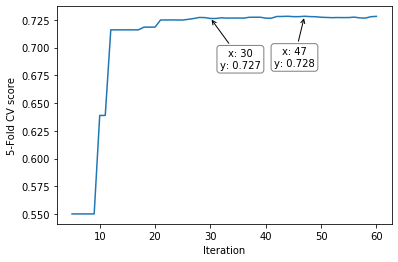

In [41]:
# Displaying a graph that can help to visualize the point where the roc-auc stops at a certain threshold
# Instead of going for the maximum value of threshold that consist of the largest number of feature, we go for the middle. 
fig, axes = plt.subplots()
sns.lineplot(tree_iterations, tree_result, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = tree_iterations[tree_result.index(max(tree_result))]
max_y_loc = max(tree_result)
axes.annotate(
    "x: {}\ny: {:.3f}".format(30, tree_result[30]), xy=(30, tree_result[30]), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(30, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
axes.annotate(
    "x: {}\ny: {:.3f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(-10, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

In [42]:
# Capture the important features into 'tree_model'
tree_model_selected_features = [key for key, val in clf_features_importance[-30:].stack().value_counts().items() if val == 7]

In [43]:
# Display the important features 
tree_model_selected_features

['second_mean',
 'velocity_z_max',
 'acceleration_x_min',
 'Speed_sum',
 'Speed_max',
 'second_max',
 'Speed_mean',
 'distance_max',
 'velocity_x_max',
 'acceleration_y_min',
 'angle_y_max']

# Linear Based Model's Feature Selection

In [44]:
# Initializing all the Linear Based Models to see which features are important for each model [Regressor]
linear_based_models = {
    "ElasticNew": ElasticNet(),
    "Huber": HuberRegressor(),
    "Linear": LinearRegression(),
    "Ridge" : Ridge(),
    "Lasso": Lasso(),
    "SGD": SGDRegressor(), 
    "PassiveAggressive": PassiveAggressiveRegressor()
}

In [45]:
# Fitting the testing dataset into each Linear Based Models
for _, clf in linear_based_models.items():
    clf.fit(X_test, y_test)

C:\Users\Jeremy\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.63113e-25): result may not be accurate.
  overwrite_a=True).T


In [46]:
# Generating the feature importance table to identify which features are crucial for the respective model
clf_features_importance = pd.DataFrame()
for name, clf in linear_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X_test.columns, np.abs(clf.coef_))
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [47]:
# Viewing the top 10 features for each model
clf_features_importance[-10:]

,ElasticNew,Huber,Linear,Ridge,Lasso,SGD,PassiveAggressive
50,velocity_z_max,velocity_y_max,Speed_mean,acceleration_y_mean,acceleration_z_sum,Accuracy_sum,Speed_sum
51,acceleration_z_sum,velocity_x_sum,acceleration_y_mean,Speed_mean,velocity_y_mean,Bearing_sum,acceleration_y_sum
52,velocity_x_max,distance_max,acceleration_x_max,acceleration_x_max,velocity_z_max,second_sum,velocity_x_max
53,distance_max,velocity_z_sum,Speed_max,Speed_max,velocity_x_max,velocity_x_sum,Accuracy_sum
54,velocity_z_mean,angle_y_sum,acceleration_y_max,acceleration_y_max,distance_max,angle_x_sum,velocity_z_max
55,acceleration_x_sum,distance_sum,gyro_x_max,gyro_x_max,velocity_z_mean,distance_sum,velocity_y_max
56,Speed_sum,Bearing_sum,acceleration_x_mean,acceleration_x_mean,velocity_x_mean,angle_z_sum,distance_max
57,velocity_x_mean,second_sum,gyro_y_mean,gyro_y_mean,Speed_sum,angle_y_sum,angle_z_sum
58,Accuracy_max,angle_x_sum,gyro_x_mean,gyro_x_mean,Accuracy_max,velocity_z_sum,second_sum
59,second_max,angle_z_sum,gyro_z_mean,gyro_z_mean,second_max,velocity_y_sum,Bearing_sum


In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 60 columns):
Accuracy_mean          19995 non-null float64
Accuracy_sum           19995 non-null float64
Accuracy_max           19995 non-null float64
Accuracy_min           19995 non-null float64
Bearing_mean           19995 non-null float64
Bearing_sum            19995 non-null float64
Bearing_max            19995 non-null float64
Bearing_min            19995 non-null float64
acceleration_x_mean    19995 non-null float64
acceleration_x_sum     19995 non-null float64
acceleration_x_max     19995 non-null float64
acceleration_x_min     19995 non-null float64
acceleration_y_mean    19995 non-null float64
acceleration_y_sum     19995 non-null float64
acceleration_y_max     19995 non-null float64
acceleration_y_min     19995 non-null float64
acceleration_z_mean    19995 non-null float64
acceleration_z_sum     19995 non-null float64
acceleration_z_max     19995 non-null float64
acceleration_z_mi

In [49]:
# Determine how many features is needed for the prediction. As too much features may cause overfitting
# Method: LinearRegression
linear_result = []
linear_iteration = list(range(30, 61))
for i in linear_iteration:
    linear_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 7]
    clf = LinearRegression()
    score = np.mean(cross_val_score(clf, X_test.loc[:, linear_model_selected_features], y_test, cv=5, scoring="roc_auc"))
    linear_result.append(score)

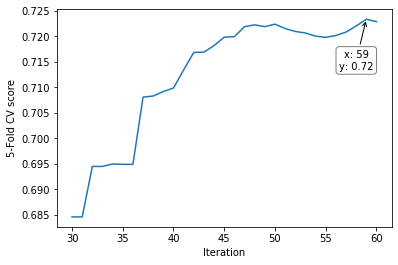

In [50]:
# Displaying a graph that can help to visualize the point where the roc-auc stops at a certain threshold
# Instead of going for the maximum value of threshold that consist of the largest number of feature, we go for the middle. 
fig, axes = plt.subplots()
sns.lineplot(linear_iteration, linear_result, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = linear_iteration[linear_result.index(max(linear_result))]
max_y_loc = max(linear_result)
axes.annotate(
    "x: {}\ny: {:.2f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(-10, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

In [51]:
# Capture the important features into 'linear_model'
linear_model_selected_features = [key for key, val in clf_features_importance[-max_x_loc:].stack().value_counts().items() if val == 7]

In [52]:
max_x_loc

59

In [53]:
# Display the important features
linear_model_selected_features

['angle_x_mean',
 'angle_z_sum',
 'gyro_x_mean',
 'acceleration_y_sum',
 'gyro_y_max',
 'gyro_x_sum',
 'Bearing_sum',
 'velocity_z_mean',
 'angle_y_mean',
 'gyro_x_max',
 'Bearing_min',
 'gyro_z_sum',
 'acceleration_z_mean',
 'Accuracy_sum',
 'angle_z_mean',
 'acceleration_y_min',
 'acceleration_x_min',
 'acceleration_x_max',
 'angle_x_max',
 'gyro_z_min',
 'acceleration_z_sum',
 'Speed_min',
 'angle_z_max',
 'angle_x_sum',
 'velocity_x_sum',
 'distance_max',
 'gyro_y_min',
 'acceleration_z_min',
 'acceleration_y_mean',
 'angle_y_max',
 'gyro_x_min',
 'Bearing_max',
 'velocity_y_mean',
 'acceleration_z_max',
 'velocity_x_max',
 'velocity_z_max',
 'Accuracy_min',
 'distance_mean',
 'acceleration_y_max',
 'distance_sum',
 'second_max',
 'Speed_max',
 'Accuracy_max',
 'velocity_x_mean',
 'velocity_z_sum',
 'Speed_sum',
 'Bearing_mean',
 'acceleration_x_mean',
 'velocity_y_max',
 'Speed_mean',
 'gyro_z_max',
 'second_mean',
 'acceleration_x_sum',
 'gyro_y_sum',
 'second_sum',
 'angle_y_sum

# 5-Fold Cross-Validation with ROC-AUC score

In [54]:
# Getting the data ready for the 5-Fold Cross-Validation with ROC-AUC score
client = Client()
kf = StratifiedKFold(n_splits=5)

def get_cv_score(clf, X_test, y_test, kf):
    cv_scores = []
    with parallel_backend("dask"):
        for _, (train_index, test_index) in enumerate(kf.split(X_test, y_test)):
            train_X, train_y = X_test.loc[train_index], y_test[train_index] 
            test_X, test_y = X_test.loc[test_index], y_test[test_index]
            clf.fit(train_X, train_y)
            y_pred = clf.predict(test_X)
            score = roc_auc_score(test_y, y_pred)
            cv_scores.append(score)
        return np.mean(cv_scores)

# Selecting of Tree Based Model

In [55]:
# perform 5-fold cross-validation of each model and return the mean value of the scores (tree-based models)
tree_cv_scores = []
for _, clf in tree_based_models.items():
    cv_score = get_cv_score(clf, X_test.loc[:, tree_model_selected_features], y_test, kf)
    tree_cv_scores.append(cv_score)

In [56]:
# Display all the accuracy of all the Tree Based Model
pd.DataFrame({"classifiers": list(tree_based_models.keys()), "CV score": tree_cv_scores}).sort_values("CV score")

,classifiers,CV score
0,DecisionTree,0.584204
5,XGB,0.690969
4,ExtraTrees,0.703027
2,AdaBoost,0.703563
1,RandomForest,0.705974
6,LGBM,0.718677
3,GradientBoosting,0.726593


# Selecting of Linear Based Model

In [57]:
# perform 5-fold cross-validation of each model and return the mean value of the scores (linear-based models)
linear_cv_scores = []
for _, clf in linear_based_models.items():
    cv_score = get_cv_score(clf, X_test.loc[:, linear_model_selected_features], y_test, kf)
    linear_cv_scores.append(cv_score)

C:\Users\Jeremy\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.70925e-25): result may not be accurate.
  overwrite_a=True).T
C:\Users\Jeremy\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.86519e-25): result may not be accurate.
  overwrite_a=True).T
C:\Users\Jeremy\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.15379e-25): result may not be accurate.
  overwrite_a=True).T
C:\Users\Jeremy\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.99147e-25): result may not be accurate.
  overwrite_a=True).T
C:\Users\Jeremy\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.62023e-25): result may not be accurate.
  overwrite_a=True).T


In [58]:
# Display all the accuracy of all the Linear Based Model
pd.DataFrame({"classifiers": list(linear_based_models.keys()), "CV score": linear_cv_scores}).sort_values("CV score")

,classifiers,CV score
5,SGD,0.497086
6,PassiveAggressive,0.505096
1,Huber,0.618446
0,ElasticNew,0.723310
4,Lasso,0.723538
2,Linear,0.723711
3,Ridge,0.723768


# Defining them into training and testing dataset

In [59]:
# Classify them into train datasets and test datasets 
train_X, test_X, train_y, test_y = train_test_split(X_test, y_test, test_size=0.2)

# Stacking technique - Ensemble Model

In [60]:
class StackingRegressor:
    def __init__(self, models, second_model, features):
        self.models = models
        self.feature_models = []
        self.second_model = second_model
        self.features = features
    
    def _generate_f_features(self, X):
        f_features = np.zeros((X.shape[0], len(self.features) * len(self.models)))
        for num, features in enumerate(self.features * len(self.models)):
            model = self.feature_models[num]
            f_features[:, num] = model.predict(X.loc[:, features[1]])
        return f_features
    
    def fit(self, X, y):
        # generate multiple trained models with different features
        for model in self.models:
            for feature in self.features:
                model.fit(X.loc[:, feature[1]], y)
                self.feature_models.append(deepcopy(model))
        f_features = self._generate_f_features(X)
        self.second_model.fit(f_features, y)
    
    def predict(self, X):
        f_features = self._generate_f_features(X)
        return self.second_model.predict(f_features)

In [61]:
# Inputting the respective features for the corresponding models
features = [
    ("manual_features", manually_selected_features),
    ("linear_features", linear_model_selected_features),
    ("tree_features", tree_model_selected_features),
]

# Saving the model

In [64]:
# Save the model and use it to predict the data later.
sr = StackingRegressor([GradientBoostingRegressor(), LinearRegression()], XGBRegressor(), features)
sr.fit(train_X, train_y)
dump(sr, "Downloads/IOT/Assignment2/stackingRegressor.joblib")

['Downloads/IOT/Assignment2/stackingRegressor.joblib']

# Analyze the results

In [65]:
# Display the accuracy of the 'Stacking Technique'
get_cv_score(StackingRegressor([GradientBoostingRegressor(), LinearRegression()], XGBRegressor(), features), X_test, y_test, kf)

0.7824152525662027

In [66]:
# Saving the prediction to variable 'y_pred'
sr = StackingRegressor([GradientBoostingRegressor(), LinearRegression()], XGBRegressor(), features)
sr.fit(train_X, train_y) # this was created in section 1.5.1
y_pred = sr.predict(test_X)

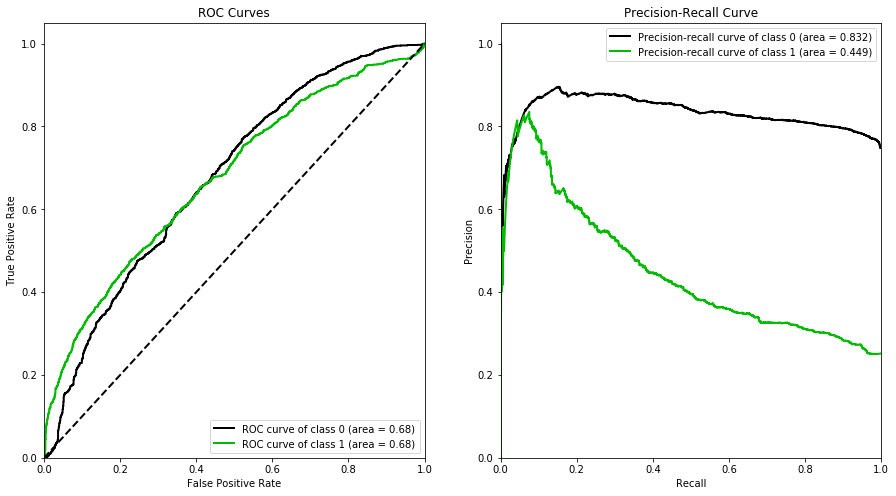

In [67]:
# Analyzing the ROC to retrieve the threshold to distingiush 'Dangerous' and 'Not Dangerous'
fig, axes = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
skplt.metrics.plot_roc(test_y, np.column_stack((1-y_pred, y_pred)), plot_macro=False, plot_micro=False, ax=axes[0])
skplt.metrics.plot_precision_recall(test_y, np.column_stack((1-y_pred, y_pred)), plot_micro=False, ax=axes[1])

In [68]:
# Viewing trips that are 'Dangerous'
y_result = np.where(y_pred > 0.8, 1, 0)

In [69]:
# Printing the accuracy for trips that are 'Dangerous'
print(classification_report(test_y, y_result))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      2992
           1       0.64      0.15      0.24      1007

    accuracy                           0.76      3999
   macro avg       0.71      0.56      0.55      3999
weighted avg       0.74      0.76      0.70      3999



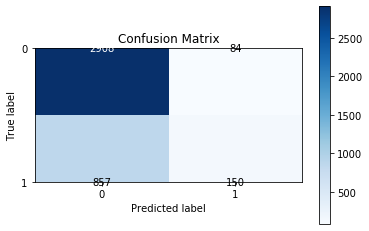

In [70]:
# Viewing the confusion matrix
skplt.metrics.plot_confusion_matrix(test_y, y_result)